In [3]:
#!pip install torch
#!conda install pytorch -c pytorch
#!pip install pypdf2
#!pip install --upgrade accelerate

In [6]:
import transformers
import torch
print(transformers.__version__)
print(torch.__version__)

4.29.2
1.13.1+cpu


In [23]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import torch
from PyPDF2 import PdfReader
from sklearn.metrics import accuracy_score
from torch.nn import Softmax

class FedReserveDataset(Dataset):
    def __init__(self, pdf_list, tokenizer, labels):
        self.pdf_list = pdf_list
        self.tokenizer = tokenizer
        self.labels = labels

    def read_pdf(self, file_path):
        with open(file_path, 'rb') as file:
            pdf_reader = PdfReader(file)
            text = ''
            for page_num in range(len(pdf_reader.pages)):
                text += pdf_reader.pages[page_num].extract_text()
        return text

    def __len__(self):
        return len(self.pdf_list)

    def __getitem__(self, idx):
        pdf = self.pdf_list[idx]
        txt = self.read_pdf(pdf)
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            txt,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            return_tensors='pt',
            truncation=True
        )
        inputs = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

        return inputs

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy,
    }

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token # Add padding token
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=3) # Increase, Decrease, Kept Flat

# Create your datasets (use your actual pdf paths and labels here, 2 raise, 1 flat, 0 decrease rate)
train_dataset = FedReserveDataset(["fomcminutes20180131_flat.pdf", "fomcminutes20180321_raise.pdf", "fomcminutes20180502_flat.pdf", "fomcminutes20180613_raise.pdf", "fomcminutes20180801_flat.pdf", "fomcminutes20180926_raise.pdf","fomcminutes20181108_flat.pdf" ], tokenizer, [1, 2, 1, 2, 1, 2, 1])
eval_dataset = FedReserveDataset(["fomcminutes20181219_raise.pdf"], tokenizer, [2])

training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=3,  # Increase number of epochs
    per_device_train_batch_size=1,
    save_steps=10_000,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,  # add this line
)

trainer.train()
trainer.evaluate()  # Add this line
model.save_pretrained("./results")

# Create an unseen dataset with the most recent Federal Reserve minutes
unseen_dataset = FedReserveDataset(["fomcminutes20181219_raise.pdf"], tokenizer, [0]) 

# Get a prediction
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # We don't need gradients for prediction
    for batch in unseen_dataset:
        # Add batch dimension
        for key in batch:
            batch[key] = batch[key].unsqueeze(0)
            
        outputs = model(**batch)
        logits = outputs.logits
        probabilities = Softmax(dim=1)(logits)  # Convert logits to probabilities

        print(probabilities)


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


tensor([[0.3694, 0.0257, 0.6049]])


In [24]:
import matplotlib.pyplot as plt
import numpy as np

# ... (the rest of your code remains the same)

# Get a prediction
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # We don't need gradients for prediction
    for batch in unseen_dataset:
        # Add batch dimension
        for key in batch:
            batch[key] = batch[key].unsqueeze(0)
        
        outputs = model(**batch)
        logits = outputs.logits
        probabilities = Softmax(dim=1)(logits)  # Convert logits to probabilities
        probabilities = probabilities.numpy()[0]  # Convert tensor to numpy array

        # Plotting
        labels = ['Decrease', 'Kept Flat', 'Increase']
        y_pos = np.arange(len(labels))

        plt.bar(y_pos, probabilities, align='center', alpha=0.5)
        plt.xticks(y_pos, labels)
        plt.ylabel('Probability')
        plt.title('Predicted Outcomes')

        plt.show()


<Figure size 640x480 with 1 Axes>

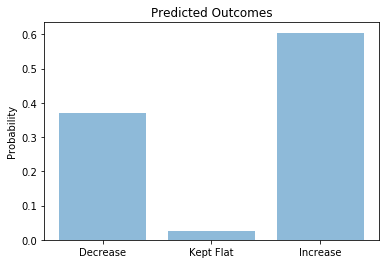

In [28]:
plt.bar(y_pos, probabilities, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Probability')
plt.title('Predicted Outcomes')

#plt.savefig('output.png')  # Saves the plot as 'output.png'
plt.show()
plt.close()  # Closes the figure
